In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score
from keras.applications import VGG16

from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from skimage.color import rgb2gray
from keras import layers, models
import cv2

from skimage import img_as_ubyte


In [10]:
sdir = r'E:\TRAINING SKRIPSI\Coba'

filepaths=[]
labels=[]
dominant_color=[] 
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths        labels
0  E:\TRAINING SKRIPSI\Coba\Belum Matang\Belum Ma...  Belum Matang
1  E:\TRAINING SKRIPSI\Coba\Belum Matang\Belum Ma...  Belum Matang
2  E:\TRAINING SKRIPSI\Coba\Belum Matang\Belum Ma...  Belum Matang
3  E:\TRAINING SKRIPSI\Coba\Belum Matang\Belum Ma...  Belum Matang
4  E:\TRAINING SKRIPSI\Coba\Belum Matang\Belum Ma...  Belum Matang
labels
Matang             300
Setengah Matang    156
Belum Matang       142
Name: count, dtype: int64


In [11]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  478   test_df length:  60   valid_df length:  60


In [12]:
height=150
width=150
channels=3
batch_size=32

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
      rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  60   test steps:  1
Found 478 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.
['Belum Matang', 'Matang', 'Setengah Matang']


In [13]:
# Membuat objek model Sequential
model = models.Sequential()

# Layer Convolutional pertama
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Layer Convolutional kedua
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Layer Convolutional ketiga
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Layer Flatten untuk mengubah output menjadi vektor 1D
model.add(layers.Flatten())

# Layer Dense (fully connected)
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))  # Misalnya, 10 kelas output

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Tampilkan ringkasan model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [16]:
base_model=tf.keras.applications.VGG16(include_top=False, weights="imagenet",input_tensor=Input(shape=(150,150,3))) 

In [17]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
def build_vgg16(input_shape=(150, 150, 3), num_classes=3):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Test the model
input_shape = (150, 150, 3)
num_classes = 3
vgg16_model = build_vgg16(input_shape, num_classes)
vgg16_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 


 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 37, 37, 128)       147584    
                                                                 
 conv2d_9 (Conv2D)           (None, 37, 37, 128)       147584    
          

In [18]:
base_model.trainable = False

In [8]:
# Define the callbacks
checkpoint = ModelCheckpoint('Belajar40.h5', save_best_only=True)

In [9]:
# Train the model
history = model.fit(train_gen, epochs=40, validation_data=valid_gen, callbacks=[checkpoint])


Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 1.1622 - accuracy: 0.4477

c:\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Python\Python311\Lib\site-packages\keras\src\regularizers.py:424: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'NoneType'>, which may lead to improper serialization.
  warnings.warn(
c:\Python\Python311\Lib\site-packages\keras\src\constraints.py:363: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'NoneType'>, which may lead to improper serialization.
  warnings.warn(


15/15 [==============================] - 57s 4s/step - loss: 1.1622 - accuracy: 0.4477 - val_loss: 0.9650 - val_accuracy: 0.5167
Epoch 2/40
15/15 [==============================] - 56s 4s/step - loss: 0.8885 - accuracy: 0.5837 - val_loss: 0.8086 - val_accuracy: 0.5333
Epoch 3/40
15/15 [==============================] - 49s 3s/step - loss: 0.5729 - accuracy: 0.7594 - val_loss: 0.3382 - val_accuracy: 0.8667
Epoch 4/40
15/15 [==============================] - 34s 2s/step - loss: 0.3654 - accuracy: 0.8536 - val_loss: 0.2633 - val_accuracy: 0.8833
Epoch 5/40
15/15 [==============================] - 41s 3s/step - loss: 0.2577 - accuracy: 0.8870 - val_loss: 0.2171 - val_accuracy: 0.9167
Epoch 6/40
15/15 [==============================] - 31s 2s/step - loss: 0.2642 - accuracy: 0.8933 - val_loss: 0.2150 - val_accuracy: 0.9000
Epoch 7/40
15/15 [==============================] - 26s 2s/step - loss: 0.2382 - accuracy: 0.9017 - val_loss: 0.2935 - val_accuracy: 0.8333
Epoch 8/40
15/15 [=============

In [10]:
# Print the test loss and accuracy
val_loss, val_acc = model.evaluate(valid_gen)
print('Validation Loss:', val_loss)
print('Validation Accuracy: {:.2f}%'.format(val_acc * 100))

2/2 [==============================] - 2s 783ms/step - loss: 0.0787 - accuracy: 0.9833
Validation Loss: 0.07866525650024414
Validation Accuracy: 98.33%


In [11]:
# Print the test loss and accuracy
val_loss, val_acc = model.evaluate(train_gen)
print('Validation Loss:', val_loss)
print('Validation Loss: {:.2f}%'.format(val_loss * 100))
print('Validation Accuracy: {:.2f}%'.format(val_acc * 100))

15/15 [==============================] - 15s 997ms/step - loss: 0.0152 - accuracy: 0.9958
Validation Loss: 0.015231463126838207
Validation Loss: 1.52%
Validation Accuracy: 99.58%


In [12]:
# Function to print text in colored foreground and background
def color_text(text, foreground_color='black', background_color='white'):
    return f'\033[38;5;{foreground_color};48;5;{background_color}m{text}\033[0m'


In [13]:
# Define a function to print information about misclassifications
def print_info(generator, preds, print_code):
    class_dict = generator.class_indices
    labels = generator.labels
    file_names = generator.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    for key, value in class_dict.items():
        new_dict[value] = key  # dictionary {integer of class number: string of class name}
    # store new_dict as a text file in the save_dir
    classes = list(new_dict.values())  # list of string of class names
    dict_as_text = str(new_dict)
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1
        y_pred.append(pred_index)
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class', 'True Class', 'Probability')
            print(msg)
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ',
                                                                         prob_list[i])
                print(msg)
        else:
            msg = 'With accuracy of 100 % there are no errors to print'
            print(msg)
    if errors > 0:
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)  # list containing how many times a class c had an error
                plot_class.append(value)  # stores the class
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
            plt.title('Errors by Class on Validation Set')
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + .5, classes, rotation=90)
        plt.yticks(np.arange(length) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)


15/15 [==============================] - 18s 985ms/step


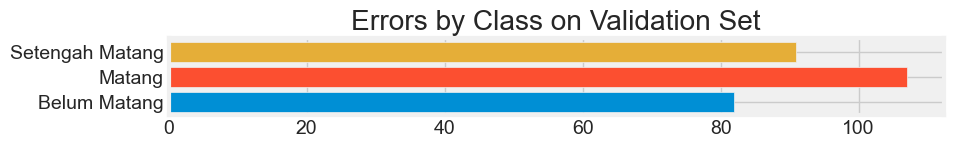

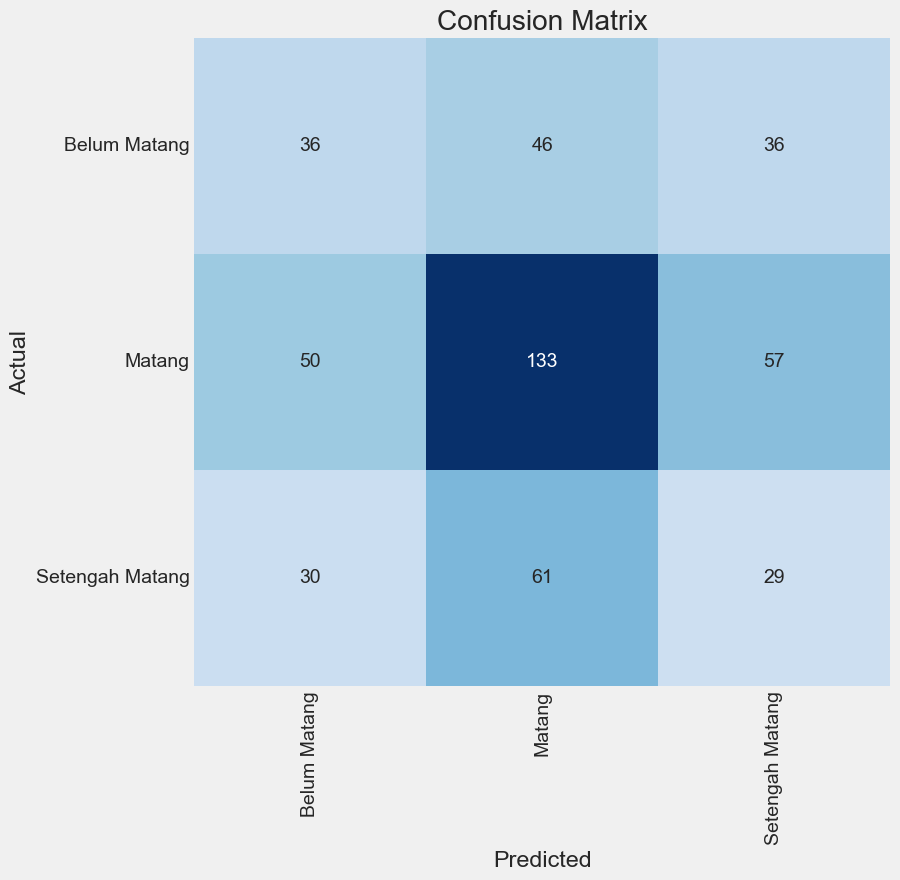

Classification Report:
----------------------
                  precision    recall  f1-score   support

   Belum Matang       0.31      0.31      0.31       118
         Matang       0.55      0.55      0.55       240
Setengah Matang       0.24      0.24      0.24       120

       accuracy                           0.41       478
      macro avg       0.37      0.37      0.37       478
   weighted avg       0.41      0.41      0.41       478



In [14]:
print_code = 0
preds = model.predict(train_gen)  # Gunakan val_generator untuk dataset validasi
print_info(train_gen, preds, print_code)

2/2 [==============================] - 2s 799ms/step


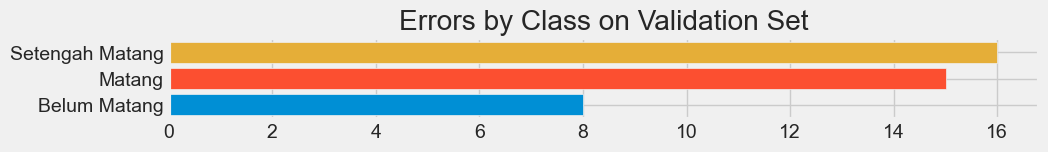

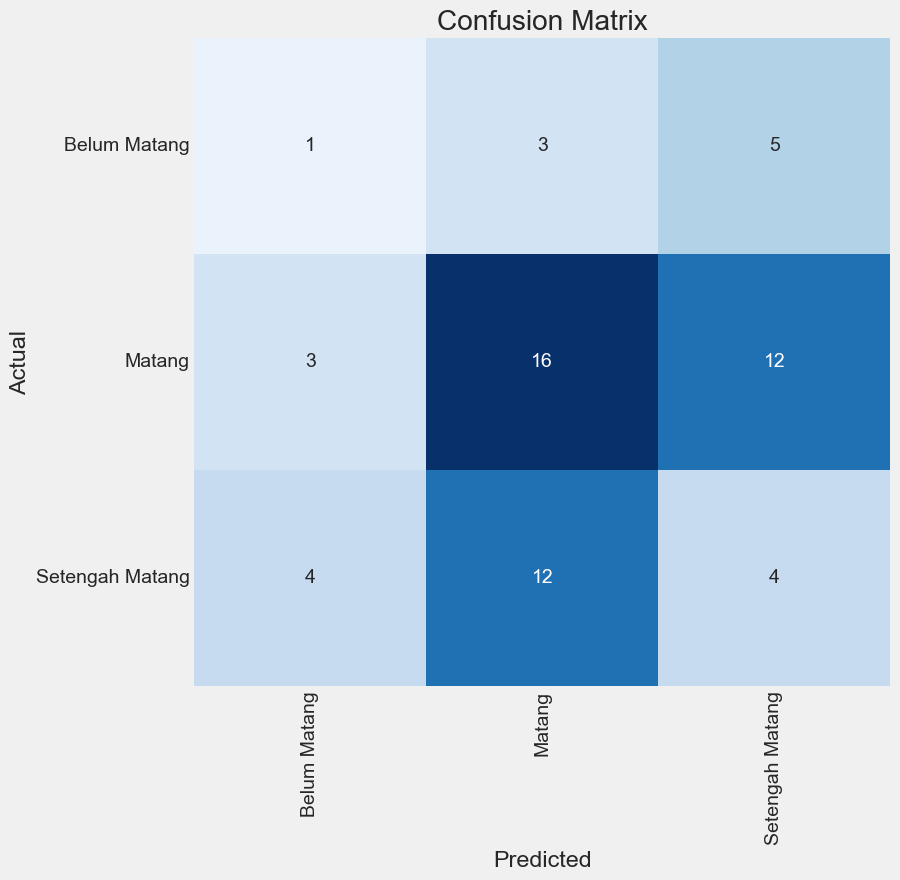

Classification Report:
----------------------
                  precision    recall  f1-score   support

   Belum Matang       0.12      0.11      0.12         9
         Matang       0.52      0.52      0.52        31
Setengah Matang       0.19      0.20      0.20        20

       accuracy                           0.35        60
      macro avg       0.28      0.28      0.28        60
   weighted avg       0.35      0.35      0.35        60



In [15]:
print_code = 0
preds = model.predict(valid_gen)  # Gunakan val_generator untuk dataset validasi
print_info(valid_gen, preds, print_code)

In [16]:
# Plot the training and validation data
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

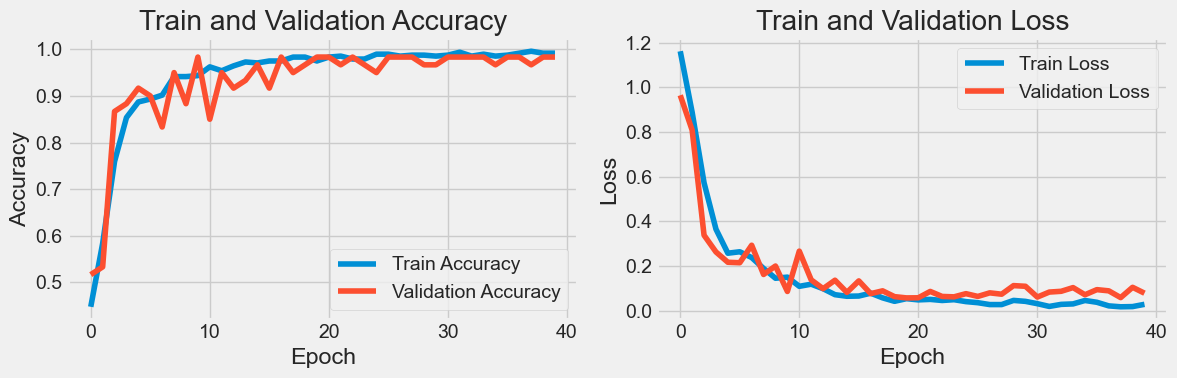

In [17]:
plot_metrics(history)


In [18]:
# Definisi fungsi tr_plot
def tr_plot(tr_data, start_epoch):
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # ini adalah epoch dengan validation loss terendah
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

# Contoh penggunaan:
# Anda harus memastikan Anda telah melatih model dan memiliki 'history' sebagai output pelatihan model Anda.
# Set juga 'start_epoch' sesuai dengan epoch awal yang digunakan dalam pelatihan Anda.
start_epoch = 1  # Ganti dengan epoch awal yang sesuai
# plot_metrics(history)  # Gunakan ini jika Anda ingin menggunakan fungsi plot_metrics
# tr_plot(history, start_epoch)  # Gunakan ini jika Anda ingin menggunakan fungsi tr_plot

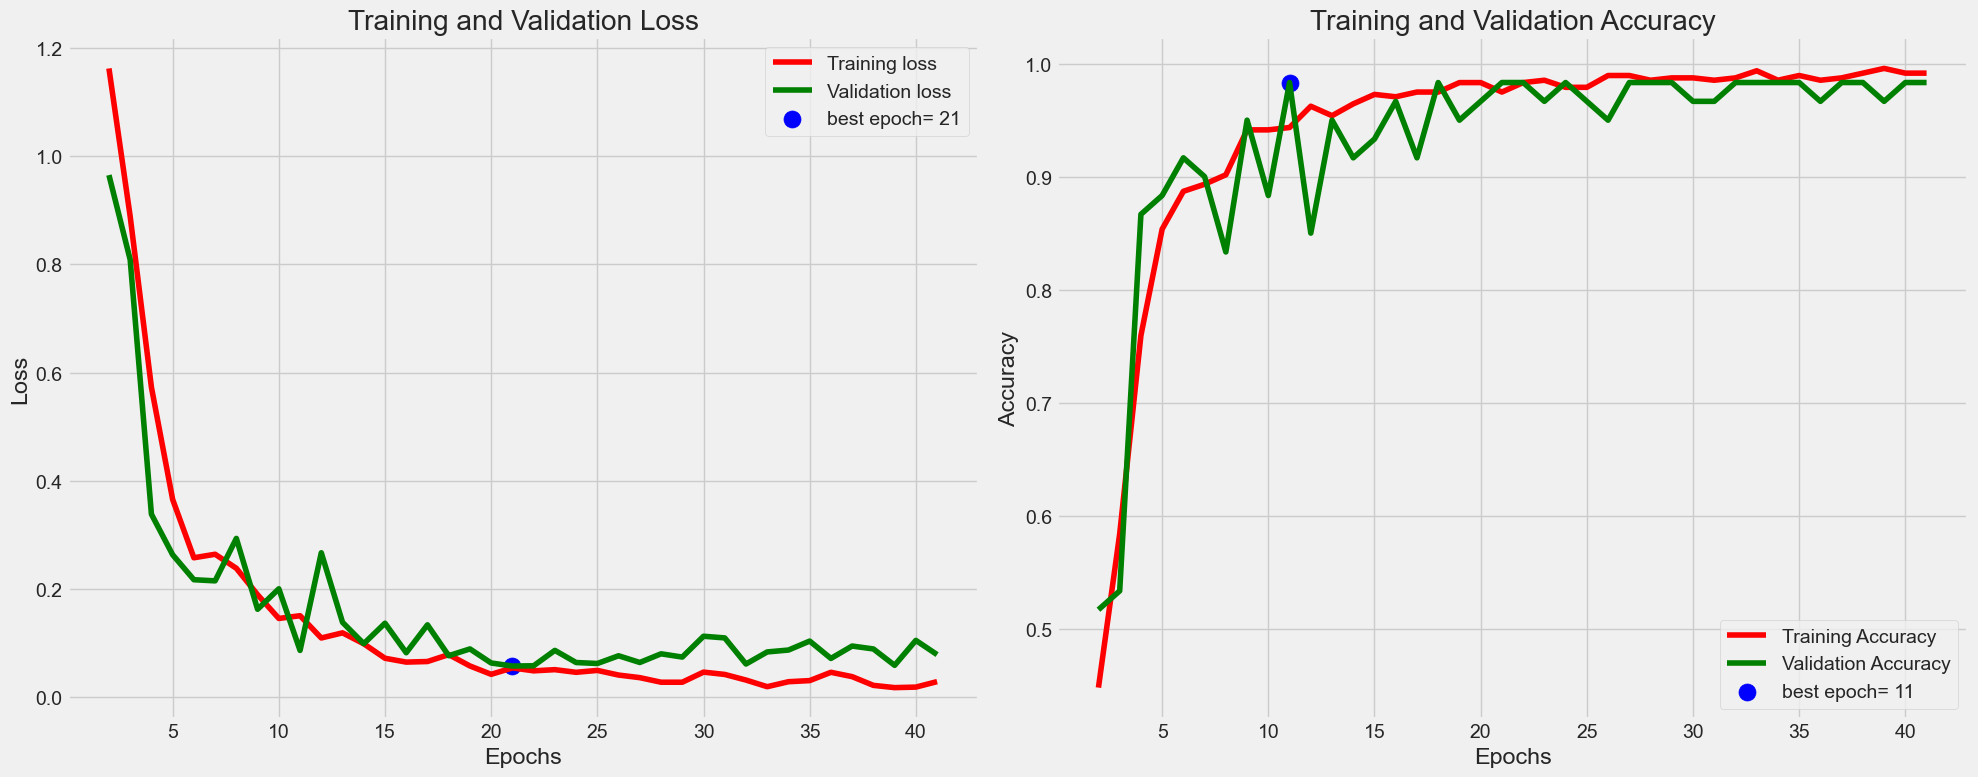

In [19]:
tr_plot(history, start_epoch) 